In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [4]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

Process Process-1:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6

In [6]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

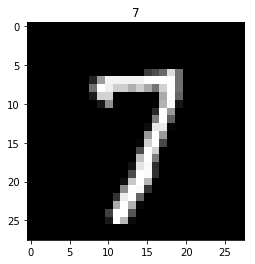

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [11]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net.cuda()

In [12]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.data[0]
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [13]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.data[0]
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum()
    return 100 * correct / total, sum_loss/ total

## Question 3.1

#### validation accuracy for the following values of learning rate 1, 0.1, 0.01, 0.001, 0.0001, 0.00001.

In [14]:
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
validation_accuracy0 = []

for r in learning_rates:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=r)
    val_acc, _, _ = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    validation_accuracy0.append(val_acc)

Epoch [1/10], Loss: 1288.9113
Epoch [1/10], Loss: 645.9625
Epoch [1/10], Loss: 433.2999
Epoch [1/10], Loss: 326.1434
Epoch [1/10], Loss: 261.6352
Epoch [1/10], Loss: 218.9867
Epoch [1/10], Loss: 188.6342
Epoch [1/10], Loss: 165.3522
Epoch [1/10], Loss: 147.2439
Epoch [1/10], Loss: 141.4490
Epoch [1/10], Valid Accuracy: 10.0600, Valid Loss: 2.4296
Epoch [2/10], Loss: 2.4474
Epoch [2/10], Loss: 2.4040
Epoch [2/10], Loss: 2.3922
Epoch [2/10], Loss: 2.4114
Epoch [2/10], Loss: 2.6289
Epoch [2/10], Loss: 3.1114
Epoch [2/10], Loss: 3.3500
Epoch [2/10], Loss: 3.2270
Epoch [2/10], Loss: 3.1318
Epoch [2/10], Loss: 3.1008
Epoch [2/10], Valid Accuracy: 10.3400, Valid Loss: 2.3965
Epoch [3/10], Loss: 2.3661
Epoch [3/10], Loss: 2.3587
Epoch [3/10], Loss: 2.3632
Epoch [3/10], Loss: 2.3629
Epoch [3/10], Loss: 2.3669
Epoch [3/10], Loss: 2.3688
Epoch [3/10], Loss: 2.3671
Epoch [3/10], Loss: 2.3658
Epoch [3/10], Loss: 2.3654
Epoch [3/10], Loss: 2.3657
Epoch [3/10], Valid Accuracy: 10.0600, Valid Loss: 2.

Epoch [6/10], Loss: 0.1474
Epoch [6/10], Loss: 0.1556
Epoch [6/10], Loss: 0.1581
Epoch [6/10], Loss: 0.1560
Epoch [6/10], Loss: 0.1547
Epoch [6/10], Loss: 0.1591
Epoch [6/10], Loss: 0.1590
Epoch [6/10], Loss: 0.1610
Epoch [6/10], Loss: 0.1604
Epoch [6/10], Loss: 0.1618
Epoch [6/10], Valid Accuracy: 95.1100, Valid Loss: 0.2292
Epoch [7/10], Loss: 0.1462
Epoch [7/10], Loss: 0.1412
Epoch [7/10], Loss: 0.1437
Epoch [7/10], Loss: 0.1478
Epoch [7/10], Loss: 0.1494
Epoch [7/10], Loss: 0.1493
Epoch [7/10], Loss: 0.1548
Epoch [7/10], Loss: 0.1603
Epoch [7/10], Loss: 0.1630
Epoch [7/10], Loss: 0.1620
Epoch [7/10], Valid Accuracy: 95.0600, Valid Loss: 0.2546
Epoch [8/10], Loss: 0.1383
Epoch [8/10], Loss: 0.1307
Epoch [8/10], Loss: 0.1333
Epoch [8/10], Loss: 0.1351
Epoch [8/10], Loss: 0.1405
Epoch [8/10], Loss: 0.1439
Epoch [8/10], Loss: 0.1457
Epoch [8/10], Loss: 0.1473
Epoch [8/10], Loss: 0.1517
Epoch [8/10], Loss: 0.1525
Epoch [8/10], Valid Accuracy: 94.8900, Valid Loss: 0.2581
Epoch [9/10], Lo

Epoch [1/10], Loss: 2.2338
Epoch [1/10], Loss: 2.1156
Epoch [1/10], Loss: 1.9991
Epoch [1/10], Loss: 1.8879
Epoch [1/10], Loss: 1.7843
Epoch [1/10], Loss: 1.6867
Epoch [1/10], Loss: 1.5998
Epoch [1/10], Loss: 1.5213
Epoch [1/10], Loss: 1.4505
Epoch [1/10], Loss: 1.4256
Epoch [1/10], Valid Accuracy: 84.7600, Valid Loss: 0.8027
Epoch [2/10], Loss: 0.7967
Epoch [2/10], Loss: 0.7696
Epoch [2/10], Loss: 0.7441
Epoch [2/10], Loss: 0.7218
Epoch [2/10], Loss: 0.7022
Epoch [2/10], Loss: 0.6887
Epoch [2/10], Loss: 0.6743
Epoch [2/10], Loss: 0.6610
Epoch [2/10], Loss: 0.6469
Epoch [2/10], Loss: 0.6424
Epoch [2/10], Valid Accuracy: 88.4300, Valid Loss: 0.5041
Epoch [3/10], Loss: 0.5131
Epoch [3/10], Loss: 0.5145
Epoch [3/10], Loss: 0.5037
Epoch [3/10], Loss: 0.4957
Epoch [3/10], Loss: 0.4898
Epoch [3/10], Loss: 0.4852
Epoch [3/10], Loss: 0.4795
Epoch [3/10], Loss: 0.4732
Epoch [3/10], Loss: 0.4692
Epoch [3/10], Loss: 0.4672
Epoch [3/10], Valid Accuracy: 90.0000, Valid Loss: 0.4060
Epoch [4/10], Lo

In [17]:
d = {'Learning_Rates': learning_rates, 'Validation_Accuracy': validation_accuracy0}
df_3_1_0 = pd.DataFrame(data=d)
df_3_1_0

,Learning_Rates,Validation_Accuracy
0,1.00000,11.59
1,0.10000,14.37
2,0.01000,95.30
3,0.00100,97.58
4,0.00010,97.47
5,0.00001,92.71


#### interpolate between the best two values (0.001, 0.0001)

In [18]:
learning_rates = np.linspace(0.0001, 0.001, 5)
validation_accuracy0 = []

for r in learning_rates:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=r)
    val_acc, _, _ = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    validation_accuracy0.append(val_acc)

Epoch [1/10], Loss: 1.3876
Epoch [1/10], Loss: 1.0028
Epoch [1/10], Loss: 0.8216
Epoch [1/10], Loss: 0.7127
Epoch [1/10], Loss: 0.6414
Epoch [1/10], Loss: 0.5931
Epoch [1/10], Loss: 0.5537
Epoch [1/10], Loss: 0.5218
Epoch [1/10], Loss: 0.4957
Epoch [1/10], Loss: 0.4883
Epoch [1/10], Valid Accuracy: 92.4900, Valid Loss: 0.2681
Epoch [2/10], Loss: 0.2608
Epoch [2/10], Loss: 0.2547
Epoch [2/10], Loss: 0.2549
Epoch [2/10], Loss: 0.2513
Epoch [2/10], Loss: 0.2499
Epoch [2/10], Loss: 0.2476
Epoch [2/10], Loss: 0.2437
Epoch [2/10], Loss: 0.2404
Epoch [2/10], Loss: 0.2378
Epoch [2/10], Loss: 0.2368
Epoch [2/10], Valid Accuracy: 94.2800, Valid Loss: 0.1995
Epoch [3/10], Loss: 0.1943
Epoch [3/10], Loss: 0.1914
Epoch [3/10], Loss: 0.1910
Epoch [3/10], Loss: 0.1913
Epoch [3/10], Loss: 0.1882
Epoch [3/10], Loss: 0.1862
Epoch [3/10], Loss: 0.1855
Epoch [3/10], Loss: 0.1842
Epoch [3/10], Loss: 0.1818
Epoch [3/10], Loss: 0.1804
Epoch [3/10], Valid Accuracy: 95.2800, Valid Loss: 0.1617
Epoch [4/10], Lo

Epoch [6/10], Loss: 0.0269
Epoch [6/10], Loss: 0.0274
Epoch [6/10], Loss: 0.0262
Epoch [6/10], Loss: 0.0269
Epoch [6/10], Loss: 0.0266
Epoch [6/10], Loss: 0.0270
Epoch [6/10], Loss: 0.0266
Epoch [6/10], Loss: 0.0272
Epoch [6/10], Loss: 0.0279
Epoch [6/10], Loss: 0.0283
Epoch [6/10], Valid Accuracy: 98.0300, Valid Loss: 0.0670
Epoch [7/10], Loss: 0.0186
Epoch [7/10], Loss: 0.0199
Epoch [7/10], Loss: 0.0195
Epoch [7/10], Loss: 0.0199
Epoch [7/10], Loss: 0.0203
Epoch [7/10], Loss: 0.0209
Epoch [7/10], Loss: 0.0214
Epoch [7/10], Loss: 0.0229
Epoch [7/10], Loss: 0.0236
Epoch [7/10], Loss: 0.0238
Epoch [7/10], Valid Accuracy: 97.8800, Valid Loss: 0.0704
Epoch [8/10], Loss: 0.0155
Epoch [8/10], Loss: 0.0148
Epoch [8/10], Loss: 0.0154
Epoch [8/10], Loss: 0.0154
Epoch [8/10], Loss: 0.0163
Epoch [8/10], Loss: 0.0167
Epoch [8/10], Loss: 0.0175
Epoch [8/10], Loss: 0.0187
Epoch [8/10], Loss: 0.0194
Epoch [8/10], Loss: 0.0195
Epoch [8/10], Valid Accuracy: 97.9100, Valid Loss: 0.0685
Epoch [9/10], Lo

In [19]:
d1 = {'Learning_Rates': learning_rates, 'Validation_Accuracy': validation_accuracy0}
df_3_1_1 = pd.DataFrame(data=d1)
df_3_1_1

,Learning_Rates,Validation_Accuracy
0,0.000100,97.75
1,0.000325,97.95
2,0.000550,97.77
3,0.000775,97.93
4,0.001000,98.03


## Question 3.2

In [24]:
M = [10, 50, 100, 300, 1000, 2000]
validation_accuracy1 = []
for m in M:
    net = get_model(m)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    validation_accuracy1.append(val_acc)

Epoch [1/10], Loss: 0.9355
Epoch [1/10], Loss: 0.7213
Epoch [1/10], Loss: 0.6519
Epoch [1/10], Loss: 0.6017
Epoch [1/10], Loss: 0.5703
Epoch [1/10], Loss: 0.5484
Epoch [1/10], Loss: 0.5330
Epoch [1/10], Loss: 0.5186
Epoch [1/10], Loss: 0.5058
Epoch [1/10], Loss: 0.5020
Epoch [1/10], Valid Accuracy: 88.6600, Valid Loss: 0.3797
Epoch [2/10], Loss: 0.4205
Epoch [2/10], Loss: 0.3968
Epoch [2/10], Loss: 0.3984
Epoch [2/10], Loss: 0.3977
Epoch [2/10], Loss: 0.3995
Epoch [2/10], Loss: 0.3999
Epoch [2/10], Loss: 0.3993
Epoch [2/10], Loss: 0.3963
Epoch [2/10], Loss: 0.3970
Epoch [2/10], Loss: 0.3959
Epoch [2/10], Valid Accuracy: 88.8300, Valid Loss: 0.3808
Epoch [3/10], Loss: 0.3784
Epoch [3/10], Loss: 0.3733
Epoch [3/10], Loss: 0.3698
Epoch [3/10], Loss: 0.3747
Epoch [3/10], Loss: 0.3801
Epoch [3/10], Loss: 0.3797
Epoch [3/10], Loss: 0.3761
Epoch [3/10], Loss: 0.3772
Epoch [3/10], Loss: 0.3780
Epoch [3/10], Loss: 0.3770
Epoch [3/10], Valid Accuracy: 89.1200, Valid Loss: 0.3588
Epoch [4/10], Lo

Epoch [6/10], Loss: 0.1437
Epoch [6/10], Loss: 0.1400
Epoch [6/10], Loss: 0.1481
Epoch [6/10], Loss: 0.1489
Epoch [6/10], Loss: 0.1504
Epoch [6/10], Loss: 0.1535
Epoch [6/10], Loss: 0.1554
Epoch [6/10], Loss: 0.1593
Epoch [6/10], Loss: 0.1602
Epoch [6/10], Loss: 0.1610
Epoch [6/10], Valid Accuracy: 94.6500, Valid Loss: 0.2393
Epoch [7/10], Loss: 0.1624
Epoch [7/10], Loss: 0.1513
Epoch [7/10], Loss: 0.1568
Epoch [7/10], Loss: 0.1536
Epoch [7/10], Loss: 0.1561
Epoch [7/10], Loss: 0.1562
Epoch [7/10], Loss: 0.1594
Epoch [7/10], Loss: 0.1606
Epoch [7/10], Loss: 0.1639
Epoch [7/10], Loss: 0.1644
Epoch [7/10], Valid Accuracy: 95.1400, Valid Loss: 0.2364
Epoch [8/10], Loss: 0.1510
Epoch [8/10], Loss: 0.1592
Epoch [8/10], Loss: 0.1630
Epoch [8/10], Loss: 0.1654
Epoch [8/10], Loss: 0.1675
Epoch [8/10], Loss: 0.1638
Epoch [8/10], Loss: 0.1632
Epoch [8/10], Loss: 0.1644
Epoch [8/10], Loss: 0.1642
Epoch [8/10], Loss: 0.1655
Epoch [8/10], Valid Accuracy: 94.6400, Valid Loss: 0.2510
Epoch [9/10], Lo

Epoch [1/10], Loss: 1.0224
Epoch [1/10], Loss: 0.6687
Epoch [1/10], Loss: 0.5413
Epoch [1/10], Loss: 0.4744
Epoch [1/10], Loss: 0.4345
Epoch [1/10], Loss: 0.4042
Epoch [1/10], Loss: 0.3841
Epoch [1/10], Loss: 0.3696
Epoch [1/10], Loss: 0.3514
Epoch [1/10], Loss: 0.3453
Epoch [1/10], Valid Accuracy: 92.7000, Valid Loss: 0.2738
Epoch [2/10], Loss: 0.2383
Epoch [2/10], Loss: 0.2231
Epoch [2/10], Loss: 0.2151
Epoch [2/10], Loss: 0.2243
Epoch [2/10], Loss: 0.2272
Epoch [2/10], Loss: 0.2268
Epoch [2/10], Loss: 0.2251
Epoch [2/10], Loss: 0.2211
Epoch [2/10], Loss: 0.2212
Epoch [2/10], Loss: 0.2236
Epoch [2/10], Valid Accuracy: 94.3500, Valid Loss: 0.2113
Epoch [3/10], Loss: 0.1739
Epoch [3/10], Loss: 0.1931
Epoch [3/10], Loss: 0.1839
Epoch [3/10], Loss: 0.1862
Epoch [3/10], Loss: 0.1907
Epoch [3/10], Loss: 0.1912
Epoch [3/10], Loss: 0.1911
Epoch [3/10], Loss: 0.1935
Epoch [3/10], Loss: 0.1966
Epoch [3/10], Loss: 0.1982
Epoch [3/10], Valid Accuracy: 94.0400, Valid Loss: 0.2250
Epoch [4/10], Lo

In [25]:
d2 = {'Size_of_Hidden_Layers': M, 'Validation_Accuracy': validation_accuracy1}
df_3_2 = pd.DataFrame(data=d2)
df_3_2

,Size_of_Hidden_Layers,Validation_Accuracy
0,10,89.94
1,50,94.77
2,100,95.02
3,300,95.23
4,1000,94.86
5,2000,95.10


The model with 1000 hidden layers has the best performance. However, most of the models are overfitting, because as validation accuracy increases, validation loss firstly decreases and then increases. 

## Question 3.3

In [34]:
decay_list = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
validation_accuracy3 = []
train_loss3 = []
validation_loss3 = []

for d in decay_list:
    net = get_model(300)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = d)
    val_acc, train_loss, val_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    print(val_acc, train_loss, val_loss)
    validation_accuracy3.append(val_acc)
    train_loss3.append(train_loss)
    validation_loss3.append(val_loss)

Epoch [1/20], Loss: 0.5748
Epoch [1/20], Loss: 0.4268
Epoch [1/20], Loss: 0.3629
Epoch [1/20], Loss: 0.3203
Epoch [1/20], Loss: 0.2891
Epoch [1/20], Loss: 0.2657
Epoch [1/20], Loss: 0.2495
Epoch [1/20], Loss: 0.2359
Epoch [1/20], Loss: 0.2241
Epoch [1/20], Loss: 0.2200
Epoch [1/20], Valid Accuracy: 96.4200, Valid Loss: 0.1101
Epoch [2/20], Loss: 0.0852
Epoch [2/20], Loss: 0.0924
Epoch [2/20], Loss: 0.0950
Epoch [2/20], Loss: 0.0914
Epoch [2/20], Loss: 0.0919
Epoch [2/20], Loss: 0.0925
Epoch [2/20], Loss: 0.0924
Epoch [2/20], Loss: 0.0912
Epoch [2/20], Loss: 0.0914
Epoch [2/20], Loss: 0.0910
Epoch [2/20], Valid Accuracy: 97.1300, Valid Loss: 0.0921
Epoch [3/20], Loss: 0.0560
Epoch [3/20], Loss: 0.0609
Epoch [3/20], Loss: 0.0603
Epoch [3/20], Loss: 0.0582
Epoch [3/20], Loss: 0.0594
Epoch [3/20], Loss: 0.0600
Epoch [3/20], Loss: 0.0601
Epoch [3/20], Loss: 0.0608
Epoch [3/20], Loss: 0.0612
Epoch [3/20], Loss: 0.0613
Epoch [3/20], Valid Accuracy: 97.6000, Valid Loss: 0.0764
Epoch [4/20], Lo

Epoch [5/20], Loss: 0.0395
Epoch [5/20], Loss: 0.0403
Epoch [5/20], Loss: 0.0414
Epoch [5/20], Loss: 0.0415
Epoch [5/20], Valid Accuracy: 97.9700, Valid Loss: 0.0685
Epoch [6/20], Loss: 0.0324
Epoch [6/20], Loss: 0.0314
Epoch [6/20], Loss: 0.0312
Epoch [6/20], Loss: 0.0321
Epoch [6/20], Loss: 0.0319
Epoch [6/20], Loss: 0.0324
Epoch [6/20], Loss: 0.0337
Epoch [6/20], Loss: 0.0350
Epoch [6/20], Loss: 0.0357
Epoch [6/20], Loss: 0.0361
Epoch [6/20], Valid Accuracy: 97.8500, Valid Loss: 0.0736
Epoch [7/20], Loss: 0.0195
Epoch [7/20], Loss: 0.0204
Epoch [7/20], Loss: 0.0246
Epoch [7/20], Loss: 0.0257
Epoch [7/20], Loss: 0.0266
Epoch [7/20], Loss: 0.0276
Epoch [7/20], Loss: 0.0289
Epoch [7/20], Loss: 0.0293
Epoch [7/20], Loss: 0.0310
Epoch [7/20], Loss: 0.0309
Epoch [7/20], Valid Accuracy: 98.0700, Valid Loss: 0.0660
Epoch [8/20], Loss: 0.0221
Epoch [8/20], Loss: 0.0193
Epoch [8/20], Loss: 0.0215
Epoch [8/20], Loss: 0.0218
Epoch [8/20], Loss: 0.0226
Epoch [8/20], Loss: 0.0236
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0492
Epoch [10/20], Loss: 0.0493
Epoch [10/20], Loss: 0.0504
Epoch [10/20], Loss: 0.0523
Epoch [10/20], Loss: 0.0533
Epoch [10/20], Loss: 0.0539
Epoch [10/20], Loss: 0.0548
Epoch [10/20], Loss: 0.0561
Epoch [10/20], Loss: 0.0579
Epoch [10/20], Loss: 0.0585
Epoch [10/20], Valid Accuracy: 97.5900, Valid Loss: 0.0790
Epoch [11/20], Loss: 0.0466
Epoch [11/20], Loss: 0.0471
Epoch [11/20], Loss: 0.0497
Epoch [11/20], Loss: 0.0510
Epoch [11/20], Loss: 0.0519
Epoch [11/20], Loss: 0.0543
Epoch [11/20], Loss: 0.0544
Epoch [11/20], Loss: 0.0563
Epoch [11/20], Loss: 0.0568
Epoch [11/20], Loss: 0.0569
Epoch [11/20], Valid Accuracy: 97.5000, Valid Loss: 0.0779
Epoch [12/20], Loss: 0.0472
Epoch [12/20], Loss: 0.0505
Epoch [12/20], Loss: 0.0495
Epoch [12/20], Loss: 0.0490
Epoch [12/20], Loss: 0.0505
Epoch [12/20], Loss: 0.0518
Epoch [12/20], Loss: 0.0529
Epoch [12/20], Loss: 0.0543
Epoch [12/20], Loss: 0.0554
Epoch [12/20], Loss: 0.0557
Epoch [12/20], Valid Accuracy: 97.4300, Va

Epoch [14/20], Loss: 0.1597
Epoch [14/20], Loss: 0.1582
Epoch [14/20], Loss: 0.1587
Epoch [14/20], Loss: 0.1588
Epoch [14/20], Loss: 0.1585
Epoch [14/20], Loss: 0.1586
Epoch [14/20], Valid Accuracy: 95.9800, Valid Loss: 0.1525
Epoch [15/20], Loss: 0.1604
Epoch [15/20], Loss: 0.1557
Epoch [15/20], Loss: 0.1536
Epoch [15/20], Loss: 0.1538
Epoch [15/20], Loss: 0.1557
Epoch [15/20], Loss: 0.1569
Epoch [15/20], Loss: 0.1572
Epoch [15/20], Loss: 0.1587
Epoch [15/20], Loss: 0.1580
Epoch [15/20], Loss: 0.1583
Epoch [15/20], Valid Accuracy: 95.9700, Valid Loss: 0.1456
Epoch [16/20], Loss: 0.1456
Epoch [16/20], Loss: 0.1471
Epoch [16/20], Loss: 0.1497
Epoch [16/20], Loss: 0.1528
Epoch [16/20], Loss: 0.1553
Epoch [16/20], Loss: 0.1562
Epoch [16/20], Loss: 0.1565
Epoch [16/20], Loss: 0.1562
Epoch [16/20], Loss: 0.1568
Epoch [16/20], Loss: 0.1565
Epoch [16/20], Valid Accuracy: 95.6000, Valid Loss: 0.1620
Epoch [17/20], Loss: 0.1565
Epoch [17/20], Loss: 0.1511
Epoch [17/20], Loss: 0.1525
Epoch [17/2

Epoch [18/20], Loss: 0.4631
Epoch [18/20], Loss: 0.4622
Epoch [18/20], Valid Accuracy: 90.2900, Valid Loss: 0.4355
Epoch [19/20], Loss: 0.4486
Epoch [19/20], Loss: 0.4634
Epoch [19/20], Loss: 0.4599
Epoch [19/20], Loss: 0.4588
Epoch [19/20], Loss: 0.4586
Epoch [19/20], Loss: 0.4595
Epoch [19/20], Loss: 0.4605
Epoch [19/20], Loss: 0.4616
Epoch [19/20], Loss: 0.4611
Epoch [19/20], Loss: 0.4606
Epoch [19/20], Valid Accuracy: 90.1500, Valid Loss: 0.4362
Epoch [20/20], Loss: 0.4598
Epoch [20/20], Loss: 0.4602
Epoch [20/20], Loss: 0.4549
Epoch [20/20], Loss: 0.4574
Epoch [20/20], Loss: 0.4609
Epoch [20/20], Loss: 0.4600
Epoch [20/20], Loss: 0.4579
Epoch [20/20], Loss: 0.4587
Epoch [20/20], Loss: 0.4609
Epoch [20/20], Loss: 0.4607
Epoch [20/20], Valid Accuracy: 89.8600, Valid Loss: 0.4328
89.86 0.43284670090675353 0.4606649178345998
Epoch [1/20], Loss: 1.0094
Epoch [1/20], Loss: 0.9355
Epoch [1/20], Loss: 0.9074
Epoch [1/20], Loss: 0.8945
Epoch [1/20], Loss: 0.8847
Epoch [1/20], Loss: 0.8775


In [42]:
d3 = {'Weight_Decay_Parameters': decay_list, 'Validation_Accuracy': validation_accuracy3, 'Train_Loss': train_loss3, 'Validation_Loss': validation_loss3}
df_3_3 = pd.DataFrame(data=d3,columns=['Weight_Decay_Parameters', 'Validation_Accuracy', 'Train_Loss','Validation_Loss'])
df_3_3

,Weight_Decay_Parameters,Validation_Accuracy,Train_Loss,Validation_Loss
0,0.0000,97.60,0.133008,0.009512
1,0.0001,97.77,0.079482,0.016285
2,0.0010,97.75,0.070739,0.049468
3,0.0100,95.92,0.150464,0.156139
4,0.1000,89.86,0.432847,0.460665
5,0.3000,85.63,0.781218,0.808879


## Question 3.4

In [43]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules).cuda()

In [44]:
dropout_list = [0.1, 0.3, 0.5, 0.7, 0.9]
validation_accuracy4 = []
train_loss4 = []
validation_loss4 = []

for d in dropout_list:
    net2 = get_model_v2(M = 300, p=d)
    optimizer = optim.Adam(net2.parameters(), lr=0.001)
    val_acc, train_loss, val_loss = train_model(train_loader, test_loader, num_epochs=20, model=net2, optimizer=optimizer)
    print(val_acc, train_loss, val_loss)
    validation_accuracy4.append(val_acc)
    train_loss4.append(round(train_loss,4))
    validation_loss4.append(round(val_loss,4))

Epoch [1/20], Loss: 0.5594
Epoch [1/20], Loss: 0.4226
Epoch [1/20], Loss: 0.3653
Epoch [1/20], Loss: 0.3304
Epoch [1/20], Loss: 0.3012
Epoch [1/20], Loss: 0.2812
Epoch [1/20], Loss: 0.2640
Epoch [1/20], Loss: 0.2496
Epoch [1/20], Loss: 0.2364
Epoch [1/20], Loss: 0.2325
Epoch [1/20], Valid Accuracy: 95.7800, Valid Loss: 0.1313
Epoch [2/20], Loss: 0.1048
Epoch [2/20], Loss: 0.1102
Epoch [2/20], Loss: 0.1063
Epoch [2/20], Loss: 0.1093
Epoch [2/20], Loss: 0.1090
Epoch [2/20], Loss: 0.1086
Epoch [2/20], Loss: 0.1062
Epoch [2/20], Loss: 0.1043
Epoch [2/20], Loss: 0.1037
Epoch [2/20], Loss: 0.1033
Epoch [2/20], Valid Accuracy: 97.4200, Valid Loss: 0.0806
Epoch [3/20], Loss: 0.0661
Epoch [3/20], Loss: 0.0709
Epoch [3/20], Loss: 0.0716
Epoch [3/20], Loss: 0.0732
Epoch [3/20], Loss: 0.0718
Epoch [3/20], Loss: 0.0724
Epoch [3/20], Loss: 0.0729
Epoch [3/20], Loss: 0.0722
Epoch [3/20], Loss: 0.0725
Epoch [3/20], Loss: 0.0724
Epoch [3/20], Valid Accuracy: 97.6300, Valid Loss: 0.0788
Epoch [4/20], Lo

Epoch [5/20], Loss: 0.0718
Epoch [5/20], Loss: 0.0717
Epoch [5/20], Loss: 0.0721
Epoch [5/20], Loss: 0.0729
Epoch [5/20], Valid Accuracy: 98.0300, Valid Loss: 0.0688
Epoch [6/20], Loss: 0.0578
Epoch [6/20], Loss: 0.0552
Epoch [6/20], Loss: 0.0563
Epoch [6/20], Loss: 0.0582
Epoch [6/20], Loss: 0.0604
Epoch [6/20], Loss: 0.0616
Epoch [6/20], Loss: 0.0629
Epoch [6/20], Loss: 0.0633
Epoch [6/20], Loss: 0.0634
Epoch [6/20], Loss: 0.0637
Epoch [6/20], Valid Accuracy: 97.8900, Valid Loss: 0.0688
Epoch [7/20], Loss: 0.0538
Epoch [7/20], Loss: 0.0543
Epoch [7/20], Loss: 0.0567
Epoch [7/20], Loss: 0.0572
Epoch [7/20], Loss: 0.0573
Epoch [7/20], Loss: 0.0597
Epoch [7/20], Loss: 0.0601
Epoch [7/20], Loss: 0.0595
Epoch [7/20], Loss: 0.0600
Epoch [7/20], Loss: 0.0606
Epoch [7/20], Valid Accuracy: 97.8300, Valid Loss: 0.0704
Epoch [8/20], Loss: 0.0506
Epoch [8/20], Loss: 0.0490
Epoch [8/20], Loss: 0.0496
Epoch [8/20], Loss: 0.0481
Epoch [8/20], Loss: 0.0498
Epoch [8/20], Loss: 0.0504
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0808
Epoch [10/20], Loss: 0.0752
Epoch [10/20], Loss: 0.0778
Epoch [10/20], Loss: 0.0766
Epoch [10/20], Loss: 0.0774
Epoch [10/20], Loss: 0.0804
Epoch [10/20], Loss: 0.0815
Epoch [10/20], Loss: 0.0792
Epoch [10/20], Loss: 0.0798
Epoch [10/20], Loss: 0.0798
Epoch [10/20], Valid Accuracy: 98.0500, Valid Loss: 0.0735
Epoch [11/20], Loss: 0.0700
Epoch [11/20], Loss: 0.0725
Epoch [11/20], Loss: 0.0742
Epoch [11/20], Loss: 0.0774
Epoch [11/20], Loss: 0.0779
Epoch [11/20], Loss: 0.0793
Epoch [11/20], Loss: 0.0801
Epoch [11/20], Loss: 0.0791
Epoch [11/20], Loss: 0.0805
Epoch [11/20], Loss: 0.0802
Epoch [11/20], Valid Accuracy: 97.9600, Valid Loss: 0.0728
Epoch [12/20], Loss: 0.0781
Epoch [12/20], Loss: 0.0767
Epoch [12/20], Loss: 0.0770
Epoch [12/20], Loss: 0.0769
Epoch [12/20], Loss: 0.0805
Epoch [12/20], Loss: 0.0824
Epoch [12/20], Loss: 0.0808
Epoch [12/20], Loss: 0.0813
Epoch [12/20], Loss: 0.0805
Epoch [12/20], Loss: 0.0806
Epoch [12/20], Valid Accuracy: 98.0900, Va

Epoch [14/20], Loss: 0.1545
Epoch [14/20], Loss: 0.1547
Epoch [14/20], Loss: 0.1555
Epoch [14/20], Loss: 0.1559
Epoch [14/20], Loss: 0.1562
Epoch [14/20], Loss: 0.1560
Epoch [14/20], Valid Accuracy: 97.6700, Valid Loss: 0.0859
Epoch [15/20], Loss: 0.1520
Epoch [15/20], Loss: 0.1441
Epoch [15/20], Loss: 0.1394
Epoch [15/20], Loss: 0.1436
Epoch [15/20], Loss: 0.1479
Epoch [15/20], Loss: 0.1525
Epoch [15/20], Loss: 0.1543
Epoch [15/20], Loss: 0.1518
Epoch [15/20], Loss: 0.1515
Epoch [15/20], Loss: 0.1517
Epoch [15/20], Valid Accuracy: 97.5800, Valid Loss: 0.0906
Epoch [16/20], Loss: 0.1463
Epoch [16/20], Loss: 0.1475
Epoch [16/20], Loss: 0.1491
Epoch [16/20], Loss: 0.1525
Epoch [16/20], Loss: 0.1506
Epoch [16/20], Loss: 0.1495
Epoch [16/20], Loss: 0.1497
Epoch [16/20], Loss: 0.1497
Epoch [16/20], Loss: 0.1509
Epoch [16/20], Loss: 0.1514
Epoch [16/20], Valid Accuracy: 97.7200, Valid Loss: 0.0785
Epoch [17/20], Loss: 0.1330
Epoch [17/20], Loss: 0.1322
Epoch [17/20], Loss: 0.1379
Epoch [17/2

Epoch [18/20], Loss: 0.4917
Epoch [18/20], Loss: 0.4913
Epoch [18/20], Valid Accuracy: 95.3600, Valid Loss: 0.1673
Epoch [19/20], Loss: 0.4771
Epoch [19/20], Loss: 0.4871
Epoch [19/20], Loss: 0.4748
Epoch [19/20], Loss: 0.4746
Epoch [19/20], Loss: 0.4821
Epoch [19/20], Loss: 0.4839
Epoch [19/20], Loss: 0.4827
Epoch [19/20], Loss: 0.4860
Epoch [19/20], Loss: 0.4857
Epoch [19/20], Loss: 0.4893
Epoch [19/20], Valid Accuracy: 95.3300, Valid Loss: 0.1615
Epoch [20/20], Loss: 0.5051
Epoch [20/20], Loss: 0.5166
Epoch [20/20], Loss: 0.5092
Epoch [20/20], Loss: 0.4992
Epoch [20/20], Loss: 0.5033
Epoch [20/20], Loss: 0.4993
Epoch [20/20], Loss: 0.4945
Epoch [20/20], Loss: 0.4937
Epoch [20/20], Loss: 0.4925
Epoch [20/20], Loss: 0.4912
Epoch [20/20], Valid Accuracy: 95.4700, Valid Loss: 0.1667
95.47 0.16672940541505812 0.4911983814398448


In [46]:
d4 = {'Dropout_Rate': dropout_list, 'Validation_Accuracy': validation_accuracy4, 'Train_Loss': train_loss4, 'Validation_Loss': validation_loss4}
df_3_4 = pd.DataFrame(data=d4)
df_3_4

,Dropout_Rate,Train_Loss,Validation_Accuracy,Validation_Loss
0,0.1,0.1032,97.91,0.0149
1,0.3,0.0794,98.27,0.0323
2,0.5,0.0762,98.21,0.0611
3,0.7,0.0935,97.69,0.1400
4,0.9,0.1667,95.47,0.4912


Dropout rate of 0.1 and 0.3 achieve the best performance, because they have the highest validation accuracy and the lowest validation loss. Comparing with the models without dropout, we can see that dropout helps to increase test accuracy.

## Question 3.5

In [47]:
def get_model_v3(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, int(.3*M)))
    modules.append(nn.ReLU())
    modules.append(nn.Linear(int(.3*M), 10))
    
    return nn.Sequential(*modules).cuda()

In [48]:
M = [100, 300]
dropout = [0.3, 0.5]
weight_decay = [0.0001, 0.001]

best_validation_accuracy = 0
best_para_list = None

for m in M:
    for d in dropout:
        for i in weight_decay:
            net3 = get_model_v3(M = m, p=d)
            optimizer = optim.Adam(net3.parameters(), lr=0.001, weight_decay = i)
            model_accuracy_loss(net, test_loader)
            val_acc, train_loss, val_loss = train_model(train_loader, test_loader, num_epochs=16, model=net3, optimizer=optimizer)
            if val_acc > best_validation_accuracy:
                best_validation_accuracy = val_acc
                best_para_list = [i, d, m]

Epoch [1/16], Loss: 1.0025
Epoch [1/16], Loss: 0.7316
Epoch [1/16], Loss: 0.6095
Epoch [1/16], Loss: 0.5380
Epoch [1/16], Loss: 0.4887
Epoch [1/16], Loss: 0.4526
Epoch [1/16], Loss: 0.4244
Epoch [1/16], Loss: 0.4024
Epoch [1/16], Loss: 0.3819
Epoch [1/16], Loss: 0.3749
Epoch [1/16], Valid Accuracy: 95.3400, Valid Loss: 0.1543
Epoch [2/16], Loss: 0.1994
Epoch [2/16], Loss: 0.2026
Epoch [2/16], Loss: 0.2042
Epoch [2/16], Loss: 0.1999
Epoch [2/16], Loss: 0.1941
Epoch [2/16], Loss: 0.1900
Epoch [2/16], Loss: 0.1903
Epoch [2/16], Loss: 0.1893
Epoch [2/16], Loss: 0.1883
Epoch [2/16], Loss: 0.1874
Epoch [2/16], Valid Accuracy: 96.2800, Valid Loss: 0.1220
Epoch [3/16], Loss: 0.1501
Epoch [3/16], Loss: 0.1490
Epoch [3/16], Loss: 0.1484
Epoch [3/16], Loss: 0.1515
Epoch [3/16], Loss: 0.1498
Epoch [3/16], Loss: 0.1512
Epoch [3/16], Loss: 0.1521
Epoch [3/16], Loss: 0.1529
Epoch [3/16], Loss: 0.1522
Epoch [3/16], Loss: 0.1526
Epoch [3/16], Valid Accuracy: 96.9400, Valid Loss: 0.0984
Epoch [4/16], Lo

Epoch [9/16], Valid Accuracy: 97.0500, Valid Loss: 0.0935
Epoch [10/16], Loss: 0.1088
Epoch [10/16], Loss: 0.1081
Epoch [10/16], Loss: 0.1176
Epoch [10/16], Loss: 0.1182
Epoch [10/16], Loss: 0.1175
Epoch [10/16], Loss: 0.1180
Epoch [10/16], Loss: 0.1184
Epoch [10/16], Loss: 0.1194
Epoch [10/16], Loss: 0.1194
Epoch [10/16], Loss: 0.1198
Epoch [10/16], Valid Accuracy: 96.9200, Valid Loss: 0.0987
Epoch [11/16], Loss: 0.1234
Epoch [11/16], Loss: 0.1231
Epoch [11/16], Loss: 0.1200
Epoch [11/16], Loss: 0.1201
Epoch [11/16], Loss: 0.1192
Epoch [11/16], Loss: 0.1206
Epoch [11/16], Loss: 0.1200
Epoch [11/16], Loss: 0.1217
Epoch [11/16], Loss: 0.1218
Epoch [11/16], Loss: 0.1213
Epoch [11/16], Valid Accuracy: 97.2000, Valid Loss: 0.0858
Epoch [12/16], Loss: 0.1104
Epoch [12/16], Loss: 0.1160
Epoch [12/16], Loss: 0.1167
Epoch [12/16], Loss: 0.1170
Epoch [12/16], Loss: 0.1166
Epoch [12/16], Loss: 0.1175
Epoch [12/16], Loss: 0.1175
Epoch [12/16], Loss: 0.1172
Epoch [12/16], Loss: 0.1168
Epoch [12/16

Epoch [2/16], Loss: 0.2708
Epoch [2/16], Loss: 0.2709
Epoch [2/16], Loss: 0.2676
Epoch [2/16], Loss: 0.2664
Epoch [2/16], Loss: 0.2647
Epoch [2/16], Valid Accuracy: 95.4700, Valid Loss: 0.1478
Epoch [3/16], Loss: 0.2277
Epoch [3/16], Loss: 0.2326
Epoch [3/16], Loss: 0.2352
Epoch [3/16], Loss: 0.2370
Epoch [3/16], Loss: 0.2372
Epoch [3/16], Loss: 0.2366
Epoch [3/16], Loss: 0.2349
Epoch [3/16], Loss: 0.2355
Epoch [3/16], Loss: 0.2343
Epoch [3/16], Loss: 0.2338
Epoch [3/16], Valid Accuracy: 95.6200, Valid Loss: 0.1414
Epoch [4/16], Loss: 0.2183
Epoch [4/16], Loss: 0.2199
Epoch [4/16], Loss: 0.2158
Epoch [4/16], Loss: 0.2119
Epoch [4/16], Loss: 0.2145
Epoch [4/16], Loss: 0.2163
Epoch [4/16], Loss: 0.2156
Epoch [4/16], Loss: 0.2155
Epoch [4/16], Loss: 0.2163
Epoch [4/16], Loss: 0.2165
Epoch [4/16], Valid Accuracy: 96.1200, Valid Loss: 0.1268
Epoch [5/16], Loss: 0.1988
Epoch [5/16], Loss: 0.2036
Epoch [5/16], Loss: 0.2011
Epoch [5/16], Loss: 0.2031
Epoch [5/16], Loss: 0.2062
Epoch [5/16], Lo

Epoch [11/16], Loss: 0.0493
Epoch [11/16], Loss: 0.0534
Epoch [11/16], Loss: 0.0518
Epoch [11/16], Loss: 0.0529
Epoch [11/16], Loss: 0.0538
Epoch [11/16], Loss: 0.0555
Epoch [11/16], Loss: 0.0554
Epoch [11/16], Loss: 0.0555
Epoch [11/16], Valid Accuracy: 98.0300, Valid Loss: 0.0670
Epoch [12/16], Loss: 0.0486
Epoch [12/16], Loss: 0.0477
Epoch [12/16], Loss: 0.0490
Epoch [12/16], Loss: 0.0502
Epoch [12/16], Loss: 0.0515
Epoch [12/16], Loss: 0.0508
Epoch [12/16], Loss: 0.0506
Epoch [12/16], Loss: 0.0526
Epoch [12/16], Loss: 0.0539
Epoch [12/16], Loss: 0.0541
Epoch [12/16], Valid Accuracy: 98.2600, Valid Loss: 0.0580
Epoch [13/16], Loss: 0.0491
Epoch [13/16], Loss: 0.0477
Epoch [13/16], Loss: 0.0490
Epoch [13/16], Loss: 0.0516
Epoch [13/16], Loss: 0.0512
Epoch [13/16], Loss: 0.0517
Epoch [13/16], Loss: 0.0515
Epoch [13/16], Loss: 0.0519
Epoch [13/16], Loss: 0.0519
Epoch [13/16], Loss: 0.0518
Epoch [13/16], Valid Accuracy: 97.9400, Valid Loss: 0.0683
Epoch [14/16], Loss: 0.0399
Epoch [14/1

Epoch [3/16], Loss: 0.1467
Epoch [3/16], Valid Accuracy: 96.4900, Valid Loss: 0.1164
Epoch [4/16], Loss: 0.1380
Epoch [4/16], Loss: 0.1336
Epoch [4/16], Loss: 0.1316
Epoch [4/16], Loss: 0.1347
Epoch [4/16], Loss: 0.1362
Epoch [4/16], Loss: 0.1318
Epoch [4/16], Loss: 0.1333
Epoch [4/16], Loss: 0.1309
Epoch [4/16], Loss: 0.1308
Epoch [4/16], Loss: 0.1311
Epoch [4/16], Valid Accuracy: 97.1500, Valid Loss: 0.0920
Epoch [5/16], Loss: 0.1114
Epoch [5/16], Loss: 0.1169
Epoch [5/16], Loss: 0.1177
Epoch [5/16], Loss: 0.1196
Epoch [5/16], Loss: 0.1194
Epoch [5/16], Loss: 0.1196
Epoch [5/16], Loss: 0.1198
Epoch [5/16], Loss: 0.1198
Epoch [5/16], Loss: 0.1210
Epoch [5/16], Loss: 0.1208
Epoch [5/16], Valid Accuracy: 97.5500, Valid Loss: 0.0813
Epoch [6/16], Loss: 0.1164
Epoch [6/16], Loss: 0.1178
Epoch [6/16], Loss: 0.1121
Epoch [6/16], Loss: 0.1086
Epoch [6/16], Loss: 0.1120
Epoch [6/16], Loss: 0.1087
Epoch [6/16], Loss: 0.1099
Epoch [6/16], Loss: 0.1099
Epoch [6/16], Loss: 0.1103
Epoch [6/16], Lo

Epoch [12/16], Loss: 0.1261
Epoch [12/16], Loss: 0.1265
Epoch [12/16], Loss: 0.1285
Epoch [12/16], Loss: 0.1302
Epoch [12/16], Loss: 0.1306
Epoch [12/16], Valid Accuracy: 97.2900, Valid Loss: 0.0801
Epoch [13/16], Loss: 0.1241
Epoch [13/16], Loss: 0.1235
Epoch [13/16], Loss: 0.1295
Epoch [13/16], Loss: 0.1300
Epoch [13/16], Loss: 0.1326
Epoch [13/16], Loss: 0.1337
Epoch [13/16], Loss: 0.1320
Epoch [13/16], Loss: 0.1327
Epoch [13/16], Loss: 0.1318
Epoch [13/16], Loss: 0.1319
Epoch [13/16], Valid Accuracy: 97.2500, Valid Loss: 0.0869
Epoch [14/16], Loss: 0.1221
Epoch [14/16], Loss: 0.1217
Epoch [14/16], Loss: 0.1275
Epoch [14/16], Loss: 0.1259
Epoch [14/16], Loss: 0.1277
Epoch [14/16], Loss: 0.1296
Epoch [14/16], Loss: 0.1292
Epoch [14/16], Loss: 0.1308
Epoch [14/16], Loss: 0.1308
Epoch [14/16], Loss: 0.1307
Epoch [14/16], Valid Accuracy: 97.2300, Valid Loss: 0.0874
Epoch [15/16], Loss: 0.1286
Epoch [15/16], Loss: 0.1273
Epoch [15/16], Loss: 0.1276
Epoch [15/16], Loss: 0.1286
Epoch [15/1

In [49]:
print('best parameters:', best_para_list)
print('best validation accuracy:', best_validation_accuracy)

best parameters: [0.0001, 0.3, 300]
best validation accuracy: 98.23


One can see that with weight decay of 0.0001, dropout rate of 0.3 and hidden layer size of 300, the 3-layer neural network has the similar performance with the 2-layer neural network. 